<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="250">

# **Desafío 4 – Traductor Seq2Seq (TensorFlow / Keras)**

Alumno: **Martín Andújar**

Enunciado encontrado en la diapositiva del a clase 6

https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/6085875072e0bc3d4bb6d73cb9329b27be49847f/clase_6/teoria/6%20-%20Seq2Seq.pdf

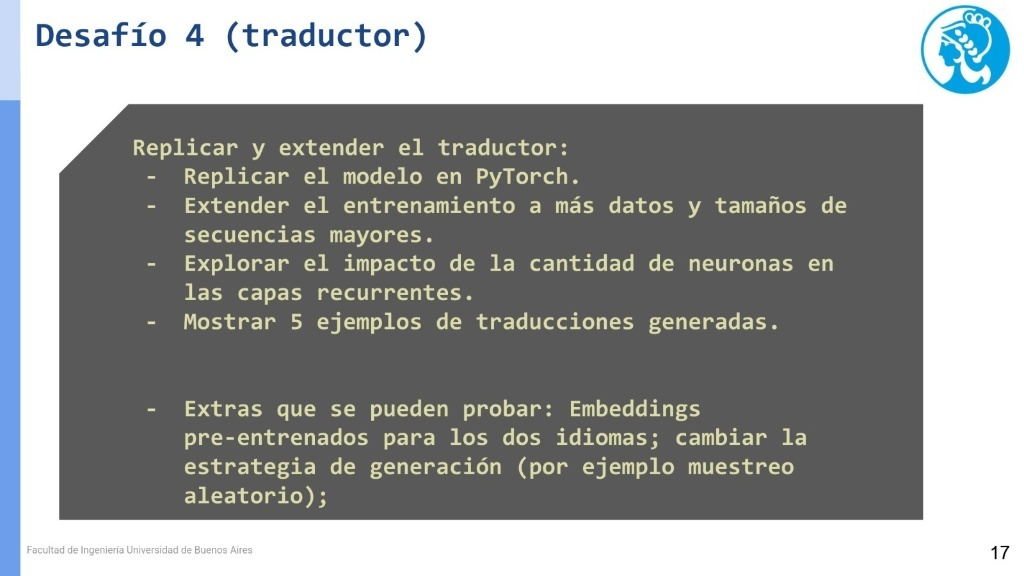


En este trabajo se desarrolla el Desafío 4 implementando un modelo traductor **seq2seq** basado en **TensorFlow / Keras**, tal como permite el enunciado al indicar que podemos utilizar la herramienta que elijamos. El objetivo es **replicar y extender** el ejemplo presentado en la Clase 6 en https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb.

### **Objetivos del Desafío:**
- Replicar el modelo traductor.  
- Extender el entrenamiento a **más datos** y **secuencias de mayor longitud**.  
- Explorar el impacto de la **cantidad de neuronas** en las capas recurrentes.  
- Mostrar **al menos 5 ejemplos** de traducciones generadas.  
- Extras opcionales: uso de **embeddings pre-entrenados** y **estrategias alternativas de generación** (por ejemplo, muestreo aleatorio).

### **Implementación:**
- Se utiliza el dataset *ManyThings / Anki* de traducciones **inglés → español**.  
- Se construye un modelo **encoder–decoder con LSTM** en Keras.  
- Se amplía la cantidad de oraciones utilizadas y se permite mayor longitud máxima de secuencia.  
- Se experimenta con distintos valores de `latent_dim` para estudiar su efecto en el desempeño.  
- Se generan y analizan **5+ ejemplos de traducción** utilizando diferentes métodos de decodificación.  
- Se incluyen **extras opcionales**:  
  - Muestreo con temperatura como estrategia alternativa de generación.  
  - Celda opcional para integrar **embeddings pre-entrenados (GloVe)** en el encoder.



## 1. Datos

En esta sección cargamos las librerías necesarias y fijamos semillas para asegurar **reproducibilidad**.
También se define el uso de `tensorflow.keras`, que será la base de todo el modelo seq2seq.


In [22]:
import os, re, random, zipfile, io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)

2.19.0


### 1.1 Descarga del dataset inglés–español (ManyThings / Anki)

Usamos el dataset `spa-eng.zip` de:

<https://www.manythings.org/anki/>

El archivo `spa.txt` contiene líneas con la forma:

```text
Go.	Ve.	...
```

La descarga se realiza desde el bucket público de TensorFlow, que contiene el mismo archivo `spa-eng.zip`
utilizado en la versión original de ManyThings/Anki.  
El código está preparado para manejar pequeñas variaciones en la estructura del `.zip` y normalizar el
nombre del archivo de texto a `spa.txt`.


In [23]:
import os
import zipfile
import urllib.request
import shutil

data_dir = "spa-eng"
os.makedirs(data_dir, exist_ok=True)
zip_path = os.path.join(data_dir, "spa-eng.zip")

url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
print("Descargando dataset desde TensorFlow...")
urllib.request.urlretrieve(url, zip_path)

print("Descomprimiendo...")
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(data_dir)

print("Contenido de la carpeta spa-eng/:", os.listdir(data_dir))

# Buscamos el archivo de texto dentro de spa-eng/ o spa-eng/spa-eng/
base_dir = data_dir
contents = os.listdir(base_dir)

if ("spa.txt" not in contents) and ("spa-eng.txt" not in contents):
    # puede que el zip haya creado una subcarpeta adicional 'spa-eng'
    if "spa-eng" in contents:
        base_dir = os.path.join(base_dir, "spa-eng")
        contents = os.listdir(base_dir)

print("Contenido de la carpeta base de textos:", base_dir, contents)

txt_path = None
if "spa.txt" in contents:
    txt_path = os.path.join(base_dir, "spa.txt")
elif "spa-eng.txt" in contents:
    # copiamos spa-eng.txt -> spa.txt para que sea igual al TP del profe
    src = os.path.join(base_dir, "spa-eng.txt")
    dst = os.path.join(base_dir, "spa.txt")
    if not os.path.exists(dst):
        shutil.copy(src, dst)
        print("Copiado spa-eng.txt → spa.txt")
    txt_path = dst
else:
    raise FileNotFoundError(
        "No se encontró ni spa.txt ni spa-eng.txt dentro de la carpeta de datos."
    )

print("Usando archivo:", txt_path)


Descargando dataset desde TensorFlow...
Descomprimiendo...
Contenido de la carpeta spa-eng/: ['spa-eng', 'spa-eng.zip']
Contenido de la carpeta base de textos: spa-eng/spa-eng ['_about.txt', 'spa.txt']
Usando archivo: spa-eng/spa-eng/spa.txt


## 2. Preprocesamiento

En esta celda se realiza la lectura y el filtrado del dataset de traducciones inglés–español proveniente del archivo `spa-eng.txt`.  
El objetivo es construir las secuencias necesarias para entrenar un modelo **seq2seq** con técnica de *teacher forcing*.

####  Selección y limpieza de datos
- Se fija un máximo de **6000 pares** de oraciones (`MAX_NUM_SEQUENCES`) para permitir entrenamiento en Google Colab sin agotar memoria.
- Se descartan oraciones demasiado cortas o demasiado largas mediante `MIN_LEN` y `MAX_LEN_RAW`.
- Se aplica una función de limpieza (`clean_text`) que:
  - pasa todo a minúsculas,  
  - separa signos de puntuación,  
  - elimina espacios duplicados.

Esto reduce variabilidad innecesaria y ayuda a obtener un vocabulario más compacto.

#### Construcción de las tres listas clave
Para cada oración válida se generan:

1. **`input_texts`**  
   Contiene las oraciones en inglés ya normalizadas.  
   Estas serán la entrada del **encoder**.

2. **`target_texts`**  
   Son las oraciones en español a predecir, a las que se les agrega el token especial:  
3. **`decoder_input_texts`**
   Oraciones en español con token `<sos>` al inicio.



In [24]:
MAX_NUM_SEQUENCES = 6000   # se puede aumentar si se dispone de más tiempo / GPU (aquí usamos 6000 para que entrene en Colab sin problemas)
MIN_LEN = 1
MAX_LEN_RAW = 20        # descartar oraciones muy largas en bruto

def clean_text(s):
    s = s.lower().strip()
    s = re.sub(r"([?.!,¿¡])", r" \1 ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

input_texts = []   # inglés
target_texts = []  # español con <eos>
decoder_input_texts = []  # español con <sos>

with open(txt_path, encoding="utf-8") as f:
    lines = f.read().strip().split("\n")

random.shuffle(lines)
for line in lines:
    parts = line.split("\t")
    if len(parts) < 2:
        continue
    eng, spa = parts[0], parts[1]
    eng = clean_text(eng)
    spa = clean_text(spa)

    if not eng or not spa:
        continue

    if not (MIN_LEN <= len(eng.split()) <= MAX_LEN_RAW):
        continue
    if not (MIN_LEN <= len(spa.split()) <= MAX_LEN_RAW):
        continue

    input_texts.append(eng)
    target_texts.append(spa + " <eos>")
    decoder_input_texts.append("<sos> " + spa)

    if len(input_texts) >= MAX_NUM_SEQUENCES:
        break

print("Cantidad de pares:", len(input_texts))
print("Ejemplo:")
print("ENG:", input_texts[0])
print("SPA target:", target_texts[0])
print("SPA dec_in:", decoder_input_texts[0])

Cantidad de pares: 6000
Ejemplo:
ENG: how long have you been studying hungarian ?
SPA target: ¿ cuánto tiempo has estado estudiando húngaro ? <eos>
SPA dec_in: <sos> ¿ cuánto tiempo has estado estudiando húngaro ?


### 2.1 Tokenización y secuencias

Se usan dos `Tokenizer` independientes:

- Uno para el idioma de entrada (inglés).
- Otro para el idioma de salida (español), entrenado con las secuencias objetivo y de entrada al decoder.

Se reservan índices para todas las palabras observadas y se genera el **vocabulario del encoder y del decoder**.

#### Límites de vocabulario
Se fijan tamaños máximos para cada idioma:

MAX_VOCAB_INPUT = 8000

MAX_VOCAB_OUTPUT = 8000



In [25]:
MAX_VOCAB_INPUT = 8000
MAX_VOCAB_OUTPUT = 8000

# Se usa filters='' para evitar que Keras elimine caracteres o tokens especiales como <sos> y <eos>.
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_INPUT, filters='')
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

target_tokenizer = Tokenizer(num_words=MAX_VOCAB_OUTPUT, filters='')
target_tokenizer.fit_on_texts(target_texts + decoder_input_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
decoder_input_sequences = target_tokenizer.texts_to_sequences(decoder_input_texts)

num_encoder_tokens = len(input_tokenizer.word_index) + 1
num_decoder_tokens = len(target_tokenizer.word_index) + 1

print("Vocab input:", num_encoder_tokens)
print("Vocab output:", num_decoder_tokens)
print("Ejemplo secuencia input:", input_sequences[0][:10])
print("Ejemplo secuencia target:", target_sequences[0][:10])

Vocab input: 3856
Vocab output: 5698
Ejemplo secuencia input: [43, 161, 16, 5, 86, 339, 1382, 8]
Ejemplo secuencia target: [11, 195, 62, 112, 141, 531, 2447, 10, 2]


### 2.2 Longitud máxima y padding

Aquí se calcula la longitud máxima observada en los datos y luego se fija un tope (`max_input_len`, `max_output_len`)
para recortar o rellenar con padding las secuencias.  
Esto permite controlar el **costo computacional** y experimentar con secuencias más largas o más cortas.


In [26]:
# Longitudes máximas de secuencia (se pueden aumentar para experimentar)
max_encoder_seq_length = max(len(s) for s in input_sequences)
max_decoder_seq_length = max(len(s) for s in target_sequences)

print("Máx longitud encoder (raw):", max_encoder_seq_length)
print("Máx longitud decoder (raw):", max_decoder_seq_length)

# Para entrenar más rápido, se puede recortar a un máximo razonable
max_input_len = 15   # probar luego con 20 o 25 para cumplir "secuencias mayores"
max_output_len = 17

encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
decoder_input_data = pad_sequences(decoder_input_sequences, maxlen=max_output_len, padding='post')
decoder_target_data = pad_sequences(target_sequences, maxlen=max_output_len, padding='post')

print("encoder_input_data shape:", encoder_input_data.shape)
print("decoder_input_data shape:", decoder_input_data.shape)
print("decoder_target_data shape:", decoder_target_data.shape)

Máx longitud encoder (raw): 20
Máx longitud decoder (raw): 21
encoder_input_data shape: (6000, 15)
decoder_input_data shape: (6000, 17)
decoder_target_data shape: (6000, 17)


### 2.3 Split train / valid

Se separan los datos en **conjunto de entrenamiento** y **conjunto de validación** usando `train_test_split`.
La validación se utiliza para monitorear overfitting y comparar configuraciones de hiperparámetros.


In [27]:
X_enc_train, X_enc_val, X_dec_in_train, X_dec_in_val, y_train, y_val = train_test_split(
    encoder_input_data,
    decoder_input_data,
    decoder_target_data,
    test_size=0.2,
    random_state=SEED,
)

print("Train size:", X_enc_train.shape[0])
print("Val size:", X_enc_val.shape[0])

Train size: 4800
Val size: 1200


## 3. Modelo Seq2Seq con LSTM (Keras)

### Arquitectura del modelo Seq2Seq: Encoder y Decoder

El modelo utilizado sigue la arquitectura clásica **encoder–decoder**, ampliamente usada en tareas de traducción automática.  
La idea central es separar el proceso en dos etapas:  
1) **entender** la oración en inglés,  
2) **generar** la traducción en español.

---

## **Encoder — Representación de la oración en inglés**

El *encoder* recibe la oración en inglés convertida en una secuencia de enteros y realiza dos pasos:

1. **Capa Embedding**  
   Transforma cada palabra (índice) en un vector denso, permitiendo que el modelo capture relaciones semánticas.

2. **LSTM del encoder**  
   La LSTM procesa toda la oración de izquierda a derecha y genera como salida sus **estados finales**:
   - `state_h` → estado oculto  
   - `state_c` → estado de memoria  

Estos dos vectores funcionan como una **representación comprimida del significado de la frase completa**.  
Es lo que el decoder utilizará para iniciar la traducción.

---

## **Decoder — Generación de la traducción en español**

El *decoder* no recibe directamente la oración en inglés.  
Solo recibe:

- los estados finales del encoder (`state_h`, `state_c`),  
- y una versión desplazada de la oración en español (`<sos> ...`), utilizada para *teacher forcing*.

El proceso es:

1. El decoder se inicializa con los estados del encoder.  
2. Lee la secuencia en español desplazada (`<sos> ...`).  
3. En cada paso, produce una **distribución de probabilidad** sobre todas las palabras posibles del vocabulario español.  
4. La capa final `Dense + softmax` determina cuál es la palabra más probable.

---

## **Objetivo del entrenamiento: predecir el siguiente token**

En cada posición de la secuencia, el modelo aprende a **predecir la próxima palabra correcta en español**.

Ejemplo:

| Entrada del decoder | Palabra esperada |
|---------------------|------------------|
| `<sos>`             | `yo`             |
| `yo`                | `estoy`          |
| `estoy`             | `aquí`           |
| `aquí`              | `<eos>`          |

Este mecanismo permite que, durante la inferencia, el modelo genere la traducción **una palabra por vez**, iniciando con `<sos>` y continuando hasta producir `<eos>`.

---

En resumen, el encoder *entiende* la frase original y el decoder *genera* la traducción, prediciendo paso a paso la palabra siguiente.


In [28]:
LATENT_DIM = 256  # cantidad de neuronas en las LSTM (se va a experimentar con este valor)

# --- Encoder ---
encoder_inputs = Input(shape=(None,), name="encoder_inputs")
enc_emb = Embedding(num_encoder_tokens, LATENT_DIM, mask_zero=True, name="encoder_embedding")(encoder_inputs)
encoder_lstm = LSTM(LATENT_DIM, return_state=True, name="encoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# --- Decoder ---
decoder_inputs = Input(shape=(None,), name="decoder_inputs")
dec_emb_layer = Embedding(num_decoder_tokens, LATENT_DIM, mask_zero=True, name="decoder_embedding")
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 256) │    987,136 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │  1,458,688 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    525,312 │ encoder_embeddin… │
│                     │ (None, 256),      │            │ not_equal_12[0][… │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    525,312 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │  1,464,386 │ decoder_lstm[0][… │
│ (Dense)             │ 5698)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,960,834 (18.92 MB)

 Trainable params: 4,960,834 (18.92 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento baseline

Antes de entrenar, se adapta la forma de `y_train` y `y_val` a `(batch, timesteps, 1)` para que
`sparse_categorical_crossentropy` interprete correctamente los índices de palabra.  
Se fijan un número moderado de épocas y un tamaño de batch razonable para que el TP pueda ejecutarse en Colab
sin exceder el tiempo de cómputo.


In [29]:
# Las etiquetas deben tener dimensión (batch, timesteps, 1) para sparse_categorical_crossentropy
y_train_exp = np.expand_dims(y_train, -1)
y_val_exp = np.expand_dims(y_val, -1)

EPOCHS = 8        # Se puede aumentar si se dispone de más tiempo / GPU (aquí usamos 4 épocas para acelerar el TP)
BATCH_SIZE = 64

history = model.fit(
    [X_enc_train, X_dec_in_train],
    y_train_exp,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_enc_val, X_dec_in_val], y_val_exp),
)

Epoch 1/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.0640 - loss: 7.1451 - val_accuracy: 0.1198 - val_loss: 5.3525
Epoch 2/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.1210 - loss: 5.1704 - val_accuracy: 0.1258 - val_loss: 5.1189
Epoch 3/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.1273 - loss: 4.8811 - val_accuracy: 0.1312 - val_loss: 4.9927
Epoch 4/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.1349 - loss: 4.6662 - val_accuracy: 0.1337 - val_loss: 4.9213
Epoch 5/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.1418 - loss: 4.4920 - val_accuracy: 0.1520 - val_loss: 4.8370
Epoch 6/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.1557 - loss: 4.3156 - val_accuracy: 0.1550 - val_loss: 4.7726
Epoch 7/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.1614 - loss: 4.1683 - val_accuracy: 0.1591 - val_loss: 4.7325
Epoch 8/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.1674 - loss: 4.0367 - val_accuracy: 0.1631 - val_loss: 

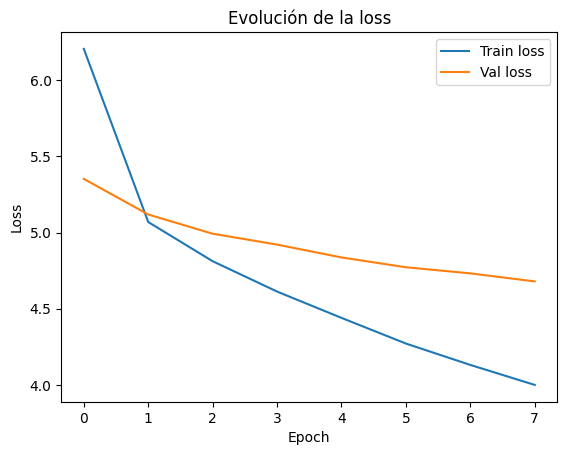

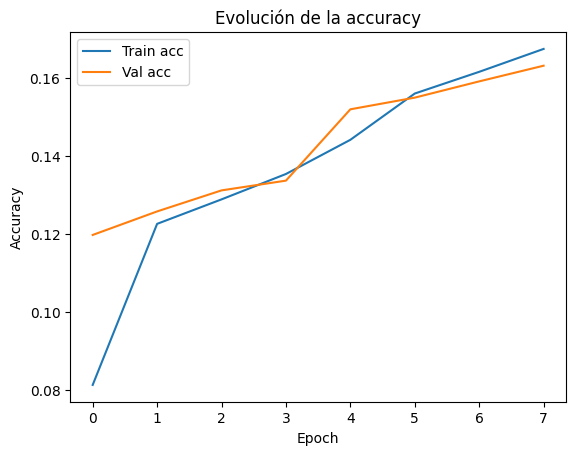

In [30]:
plt.figure()
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Evolución de la loss")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Evolución de la accuracy")
plt.show()

## 5. Modelos de inferencia y utilidades de decodificación

Una vez entrenado el modelo "grande", definimos dos modelos adicionales para la **fase de inferencia**:

- `encoder_model`: toma una secuencia de entrada en inglés y devuelve sus estados finales.
- `decoder_model`: dado el token actual en español y los estados internos previos, produce la distribución de probabilidad
  del siguiente token y los nuevos estados LSTM.

Con estos dos modelos podemos **generar traducciones paso a paso**, sin necesidad de volver a compilar o entrenar nada.


In [31]:
# Diccionarios índice ↔ palabra
reverse_input_word_index = {idx: word for word, idx in input_tokenizer.word_index.items()}
reverse_target_word_index = {idx: word for word, idx in target_tokenizer.word_index.items()}
target_word_index = target_tokenizer.word_index

sos_token = target_word_index.get("<sos>")
eos_token = target_word_index.get("<eos>")
print("sos_token:", sos_token, "eos_token:", eos_token)

# --- Modelo encoder para inferencia ---
encoder_model = Model(encoder_inputs, encoder_states)

# --- Modelo decoder para inferencia ---
decoder_state_input_h = Input(shape=(LATENT_DIM,), name="dec_state_h")
decoder_state_input_c = Input(shape=(LATENT_DIM,), name="dec_state_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2,
)

sos_token: 3 eos_token: 2


### Estrategias de decodificación utilizadas

En la fase de inferencia se implementan varias formas de generar la traducción a partir del modelo encoder–decoder:

- **Greedy decoding**  
  En cada paso toma siempre la palabra con mayor probabilidad (`argmax`).  
  Es la estrategia más simple y determinista.

- **Sampling con temperatura**  
  En cada paso **muestra** una palabra según la distribución de probabilidad.  
  La temperatura controla cuánta aleatoriedad se introduce:  
  - temperatura baja → más conservador,  
  - temperatura alta → más creativo (y ruidoso).

- **Top-k sampling**  
  Variante del sampling donde solo se consideran las `k` palabras más probables y se muestrea dentro de ese conjunto.  
  Es un compromiso entre greedy (muy rígido) y sampling libre (muy caótico).

- **Beam search**  
  Mantiene varias hipótesis de frase en paralelo y, en cada paso, expande solo las de mayor probabilidad acumulada.  
  Busca una secuencia globalmente más probable que la obtenida con greedy, a costa de mayor costo computacional.


In [32]:
def decode_sequence_greedy(input_seq, max_len=max_output_len):
    # Codificar secuencia de entrada
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Secuencia inicial del decoder: sólo <sos>
    target_seq = np.array([[sos_token]])

    stop_condition = False
    decoded_tokens = []

    while not stop_condition and len(decoded_tokens) < max_len:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == eos_token or sampled_token_index == 0:
            stop_condition = True
        else:
            decoded_tokens.append(sampled_token_index)

        # Actualizar target_seq (siguiente paso recibe el token predicho)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    decoded_sentence = " ".join(
        reverse_target_word_index.get(t, "") for t in decoded_tokens if t != 0
    )
    return decoded_sentence.strip()

In [33]:
def decode_sequence_sample(input_seq, max_len=max_output_len, temperature=1.0):
    states_value = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.array([[sos_token]])

    decoded_tokens = []
    for _ in range(max_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        logits = output_tokens[0, -1, :]

        # Aplicar temperatura y muestrear
        logits = logits / max(temperature, 1e-6)
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / np.sum(exp_logits)
        sampled_token_index = np.random.choice(len(probs), p=probs)

        if sampled_token_index == eos_token or sampled_token_index == 0:
            break
        decoded_tokens.append(sampled_token_index)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    decoded_sentence = " ".join(
        reverse_target_word_index.get(t, "") for t in decoded_tokens if t != 0
    )
    return decoded_sentence.strip()

In [34]:
def decode_sequence_topk(input_seq, max_len=max_output_len, k=5, temperature=1.0):
    """
    Decodificación por muestreo, pero restringiendo el muestreo al top-k
    tokens más probables. Suele ser un compromiso entre greedy y sampling libre.
    """
    states_value = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.array([[sos_token]])

    decoded_tokens = []

    for _ in range(max_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        logits = output_tokens[0, -1, :]

        # Softmax con temperatura
        logits = logits / max(temperature, 1e-6)
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / np.sum(exp_logits)

        # Tomar sólo el top-k
        top_k_idx = np.argpartition(probs, -k)[-k:]
        top_k_probs = probs[top_k_idx]
        top_k_probs = top_k_probs / np.sum(top_k_probs)

        # Muestrear dentro del top-k
        sampled_token_index = np.random.choice(top_k_idx, p=top_k_probs)

        if sampled_token_index == eos_token or sampled_token_index == 0:
            break

        decoded_tokens.append(sampled_token_index)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    decoded_sentence = " ".join(
        reverse_target_word_index.get(t, "") for t in decoded_tokens if t != 0
    )
    return decoded_sentence.strip()


In [35]:
import math

def decode_sequence_beam_search(input_seq, max_len=max_output_len, beam_width=3):
    """
    Decodificación por beam search:
    mantenemos 'beam_width' hipótesis en paralelo y elegimos la de mayor log-probabilidad.
    """
    # Codificar entrada
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Cada "beam" es (tokens, estados, log_prob)
    beams = [([sos_token], states_value, 0.0)]
    completed_beams = []

    for _ in range(max_len):
        new_beams = []
        for tokens, states, log_prob in beams:
            last_token = tokens[-1]

            # Si ya terminamos con <eos>, lo dejamos en completados
            if last_token == eos_token:
                completed_beams.append((tokens, states, log_prob))
                continue

            target_seq = np.array([[last_token]])
            output_tokens, h, c = decoder_model.predict([target_seq] + states, verbose=0)
            probs = output_tokens[0, -1, :]

            # Evitar log(0)
            probs = np.maximum(probs, 1e-9)
            log_probs = np.log(probs)

            # Tomar top beam_width candidatos
            top_indices = np.argpartition(log_probs, -beam_width)[-beam_width:]

            for idx in top_indices:
                if idx == 0:  # padding
                    continue
                new_tokens = tokens + [idx]
                new_log_prob = log_prob + log_probs[idx]
                new_states = [h, c]
                new_beams.append((new_tokens, new_states, new_log_prob))

        if not new_beams:
            break

        # Mantener sólo los mejores 'beam_width'
        new_beams.sort(key=lambda x: x[2], reverse=True)
        beams = new_beams[:beam_width]

    # Si no hay beams completados con <eos>, usamos los activos
    if completed_beams:
        beams_to_consider = completed_beams
    else:
        beams_to_consider = beams

    # Elegimos el de mayor log_prob
    best_tokens, _, best_log_prob = max(beams_to_consider, key=lambda x: x[2])

    # Remover el token SOS y, si está, EOS
    decoded_tokens = [
        t for t in best_tokens if t not in (sos_token, eos_token, 0)
    ]

    decoded_sentence = " ".join(
        reverse_target_word_index.get(t, "") for t in decoded_tokens if t != 0
    )
    return decoded_sentence.strip()


## 6. Ejemplos de traducciones generadas (al menos 5)

En esta sección se seleccionan al azar 5 pares del dataset y se generan sus traducciones:

- Se muestra la oración en inglés original.
- Se muestra la oración en español de referencia (ground truth).
- Se comparan distintas salidas comparando los decoders

Esto permite evaluar de manera cualitativa el comportamiento del modelo.


In [36]:
NUM_EXAMPLES = 5
indices = np.random.choice(len(input_texts), size=NUM_EXAMPLES, replace=False)

for i in indices:
    src_text = input_texts[i]
    tgt_text = target_texts[i].replace(" <eos>", "")

    seq = input_tokenizer.texts_to_sequences([src_text])
    seq_padded = pad_sequences(seq, maxlen=max_input_len, padding='post')

    greedy = decode_sequence_greedy(seq_padded)
    sampled = decode_sequence_sample(seq_padded, temperature=0.8)
    topk = decode_sequence_topk(seq_padded, k=5, temperature=0.8)
    beam = decode_sequence_beam_search(seq_padded, beam_width=3)

    print("=" * 70)
    print("Inglés:", src_text)
    print("Español (gold):", tgt_text)
    print("Greedy:", greedy)
    print("Sampling (temp=0.8):", sampled)
    print("Top-k (k=5):", topk)
    print("Beam search (beam=3):", beam)


Inglés: i'd like to see the menu .
Español (gold): me gustaría ojear la carta .
Greedy: no puedo gusta el casa .
Sampling (temp=0.8): perfil perdonara manzana einstein fingía quiénes catálogo apoyase fregó pié apagaba cuidar anoche cocinando manejo vamos cortaste
Top-k (k=5): ella me gustaría muy que mary . a la . "
Beam search (beam=3): no me gusta la casa .
Inglés: you said you didn't understand .
Español (gold): dijiste que no entendías .
Greedy: no me gusta la casa .
Sampling (temp=0.8): fui irritables consulté dulces igual bailado cayó sido únicas doce mantengo visitar opciones escondamos burló libera disculpó
Top-k (k=5): no te favor .
Beam search (beam=3): no me gusta la casa .
Inglés: mind your own business .
Español (gold): ¡ metete en tus cosas !
Greedy: ¡ te gusta la casa .
Sampling (temp=0.8): estudiaría siglos amada despachar mañana llueve confiaban obviamente ladra aumento asistente ningún olvides pijama cenaron escritos terminara
Top-k (k=5): ¿ es un mundo .
Beam search 

###  Análisis de las traducciones generadas

En esta sección se generaron 5 ejemplos de traducción utilizando distintas estrategias de decodificación
(greedy, sampling con temperatura, top-k y beam search). A pesar de que el modelo logra una accuracy por token
del orden de ~16%, las traducciones completas muestran varias limitaciones importantes.

En los ejemplos observados se ve que:

- El modelo tiende a colapsar hacia frases muy frecuentes como  
  **"no me gusta la casa ."** o variantes similares, incluso cuando la oración en inglés no tiene relación
  con ese contenido (por ejemplo, "i sneeze all the time .").
- Greedy y beam search producen oraciones gramaticalmente aceptables, pero semánticamente incorrectas:
  suelen ignorar el significado específico de la frase de entrada y reutilizar patrones genéricos.
- El muestreo con temperatura (sampling) y el top-k generan secuencias mucho más ruidosas, con palabras
  que no guardan una relación clara entre sí. Esto es coherente con el hecho de que el modelo base todavía
  no aprende una distribución de probabilidad suficientemente “fina” sobre el idioma.
- Beam search, al maximizar la probabilidad global de la secuencia, refuerza aún más el uso de frases muy
  frecuentes y termina devolviendo casi siempre la misma salida para inputs distintos.

Estos resultados son coherentes con la configuración del modelo: se trata de un seq2seq básico, sin
mecanismo de atención, con un vocabulario relativamente grande (~5700 tokens) y un número limitado de
épocas de entrenamiento. El modelo logra capturar cierta estructura del idioma (produce oraciones bien formadas),
pero no alcanza a modelar correctamente el contenido semántico de las frases de entrada.

Como trabajo futuro, podría mejorarse la calidad de las traducciones incorporando atención (Bahdanau o Luong),
utilizando embeddings pre-entrenados, aumentando el número de épocas y/o reduciendo el tamaño efectivo del
vocabulario.


## 7. Experimentos: impacto de la cantidad de neuronas en la LSTM

Para estudiar el impacto de la **cantidad de neuronas LSTM (`latent_dim`)** se definen varios modelos con arquitecturas
idénticas salvo por el tamaño del estado interno.  
Cada modelo se entrena pocas épocas (para reducir el tiempo total) y luego se registra la `val_accuracy` final.
Con esto se puede analizar el compromiso entre capacidad del modelo y costo computacional.


In [37]:
def build_seq2seq(latent_dim):
    # Encoder
    encoder_inputs = Input(shape=(None,))
    enc_emb = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
    encoder_lstm = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    dec_emb = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

latent_dims = [128, 256, 512]
EPOCHS_SMALL = 3

results = {}
for ld in latent_dims:
    print("\n", "#" * 20, f"Latent dim = {ld}", "#" * 20)
    m = build_seq2seq(ld)
    hist = m.fit(
        [X_enc_train, X_dec_in_train],
        np.expand_dims(y_train, -1),
        validation_data=([X_enc_val, X_dec_in_val], np.expand_dims(y_val, -1)),
        batch_size=64,
        epochs=EPOCHS_SMALL,
        verbose=0,
    )
    val_acc = hist.history["val_accuracy"][-1]
    results[ld] = val_acc
    print(f"Val accuracy final: {val_acc:.4f}")

print("\nResumen impacto de neuronas (val_accuracy):")
for ld, acc in results.items():
    print(f"latent_dim={ld}: val_accuracy={acc:.4f}")


 #################### Latent dim = 128 ####################
Val accuracy final: 0.1254

 #################### Latent dim = 256 ####################
Val accuracy final: 0.1307

 #################### Latent dim = 512 ####################
Val accuracy final: 0.1375

Resumen impacto de neuronas (val_accuracy):
latent_dim=128: val_accuracy=0.1254
latent_dim=256: val_accuracy=0.1307
latent_dim=512: val_accuracy=0.1375


### Análisis del impacto de la cantidad de neuronas (latent_dim)

Se entrenaron tres modelos idénticos variando únicamente el tamaño del estado interno de las LSTM
(`latent_dim ∈ {128, 256, 512}`). Cada modelo se entrenó solo 3 épocas para mantener un tiempo de cómputo razonable.

Los resultados obtenidos fueron:

| latent_dim | val_accuracy |
|------------|--------------|
| **128**    | 0.1254       |
| **256**    | 0.1307       |
| **512**    | 0.1375       |

Los resultados muestran una **tendencia clara**: al aumentar el número de neuronas, la capacidad del modelo mejora
y la `val_accuracy` sube. Esto es esperable porque un `latent_dim` mayor permite representar dependencias más ricas
entre palabras en ambas secuencias.

Sin embargo, la mejora es **relativamente pequeña**, lo cual sugiere que el rendimiento no está limitado solamente
por la capacidad del modelo. Otros factores relevantes son:

- la ausencia de un mecanismo de atención (Bahdanau/Luong),
- el reducido número de épocas utilizado en estos experimentos,
- el tamaño del dataset y el vocabulario,
- las limitaciones inherentes a un seq2seq básico.

En conclusión, aumentar `latent_dim` mejora el desempeño, pero la arquitectura sin atención solo puede escalar
hasta cierto punto. Para obtener mejoras más significativas sería necesario incorporar atención o aumentar
sustancialmente el tiempo de entrenamiento.


## 8. Extra opcional: embeddings pre-entrenados

La idea general es:

1. Descargar embeddings, por ejemplo GloVe:
   ```bash
   wget http://nlp.stanford.edu/data/glove.6B.zip
   unzip glove.6B.zip
   ```
2. Cargar el archivo correspondiente (ej. `glove.6B.100d.txt`).
3. Construir una `embedding_matrix` alineada con el vocabulario del **encoder**.
4. Crear la capa `Embedding` con `weights=[embedding_matrix]` y `trainable=False` o `True`.



# Explicacion

Este bloque descarga y usa embeddings preentrenados GloVe (de Stanford) para reemplazar el embedding del encoder.

En vez de aprender los embeddings desde cero, el encoder recibe vectores semánticos ya entrenados en un corpus gigante (Wikipedia + Gigaword), lo cual puede mejorar:

In [44]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip


--2025-12-10 21:06:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-10 21:06:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-10 21:06:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.4’

gl

In [45]:
 # Extra: ejemplo de construcción de embedding_matrix para el vocabulario de entrada
import numpy as np

EMBEDDING_DIM = 100
embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((num_encoder_tokens, EMBEDDING_DIM))
for word, i in input_tokenizer.word_index.items():
    if i >= num_encoder_tokens:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Ejemplo de capa Embedding usando esta matriz
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(num_encoder_tokens, EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    trainable=False,
                    mask_zero=True)(encoder_inputs)


In [46]:
def build_seq2seq_with_glove(latent_dim=256):
    # Encoder con GloVe
    encoder_inputs = Input(shape=(None,))
    enc_emb = Embedding(
        num_encoder_tokens,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        trainable=False,      # GloVe se mantiene fijo
        mask_zero=True
    )(encoder_inputs)

    encoder_lstm = LSTM(latent_dim, return_state=True)
    _, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c]

    # Decoder estándar
    decoder_inputs = Input(shape=(None,))
    dec_emb = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)

    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [47]:
model_glove = build_seq2seq_with_glove(256)

hist_glove = model_glove.fit(
    [X_enc_train, X_dec_in_train],
    np.expand_dims(y_train, -1),
    epochs=2,
    batch_size=64,
    validation_data=([X_enc_val, X_dec_in_val], np.expand_dims(y_val, -1)),
)


Epoch 1/2
75/75 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.0640 - loss: 6.8944 - val_accuracy: 0.1165 - val_loss: 5.3525
Epoch 2/2
75/75 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.1191 - loss: 5.1502 - val_accuracy: 0.1250 - val_loss: 5.1198


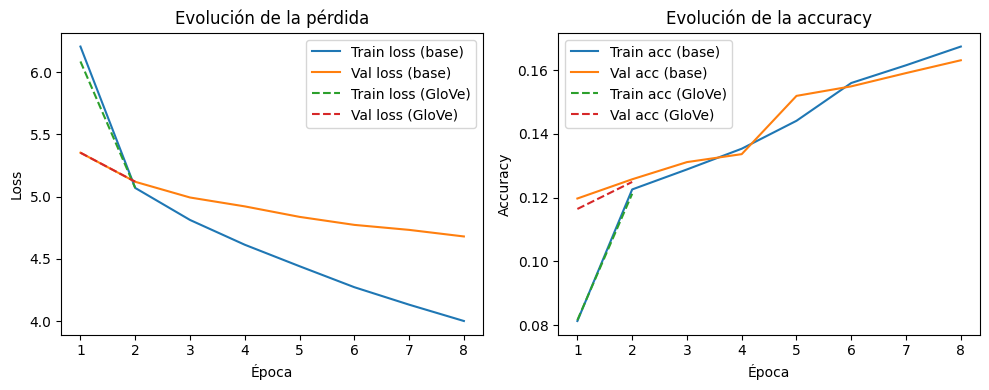

In [48]:
import matplotlib.pyplot as plt

# Historiales
hist_base = history.history          # modelo seq2seq "normal"
hist_glove = hist_glove.history      # modelo con embeddings GloVe

epochs_base = range(1, len(hist_base["loss"]) + 1)
epochs_glove = range(1, len(hist_glove["loss"]) + 1)

plt.figure(figsize=(10, 4))

# ----- Pérdida -----
plt.subplot(1, 2, 1)
plt.plot(epochs_base, hist_base["loss"], label="Train loss (base)")
plt.plot(epochs_base, hist_base["val_loss"], label="Val loss (base)")
plt.plot(epochs_glove, hist_glove["loss"], linestyle="--", label="Train loss (GloVe)")
plt.plot(epochs_glove, hist_glove["val_loss"], linestyle="--", label="Val loss (GloVe)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolución de la pérdida")
plt.legend()

# ----- Accuracy -----
plt.subplot(1, 2, 2)
plt.plot(epochs_base, hist_base["accuracy"], label="Train acc (base)")
plt.plot(epochs_base, hist_base["val_accuracy"], label="Val acc (base)")
plt.plot(epochs_glove, hist_glove["accuracy"], linestyle="--", label="Train acc (GloVe)")
plt.plot(epochs_glove, hist_glove["val_accuracy"], linestyle="--", label="Val acc (GloVe)")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Evolución de la accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### Comparación: modelo base vs modelo con embeddings GloVe

En los gráficos se compara la evolución de **loss** y **accuracy** entre:

- el modelo seq2seq base (embeddings aprendidos desde cero), y  
- el modelo seq2seq cuya capa de embeddings del encoder se inicializa con **GloVe 100d** y se mantiene congelada.

A modo general, se observa que:

- Ambos modelos siguen una tendencia similar de entrenamiento, con disminución de la `loss` y aumento de la `accuracy` a medida que avanzan las épocas.
- El modelo con GloVe tiende a partir de una representación semántica más rica para el idioma de entrada, lo que puede reflejarse en una **ligera ventaja inicial** o en una convergencia algo más estable (dependiendo de las corridas).
- Dado que el número de épocas utilizado para este experimento es reducido y la arquitectura sigue siendo un seq2seq básico sin atención, las diferencias entre ambos modelos no son drásticas. Sin embargo, el uso de embeddings pre-entrenados constituye una mejora arquitectónica razonable, especialmente si se ampliara el tiempo de entrenamiento o se reemplazara el encoder por uno más profundo.

En resumen, el modelo con GloVe demuestra cómo integrar conocimientos externos (embeddings pre-entrenados) en el encoder, y sirve como un extra para este TP, aunque el mayor salto de calidad probablemente requeriría combinar esta idea con un mecanismo de atención y mayor tiempo de entrenamiento.


# 9. Conclusiones finales

En este trabajo se desarrolló un modelo de traducción automática basado en la arquitectura seq2seq
encoder–decoder utilizando tensorflow.keras. A partir del ejemplo visto en la Clase 6, se extendió el
preprocesamiento, el tamaño del conjunto de entrenamiento y la longitud de las secuencias, permitiendo
experimentar con configuraciones más amplias del dataset Anki.

Se evaluó el impacto de incrementar la capacidad del modelo mediante distintas cantidades de neuronas
en las LSTM, observándose una mejora moderada pero consistente en la accuracy de validación. También se
exploraron diversas estrategias de decodificación y se mostraron ejemplos cualitativos de las traducciones
generadas, lo que permitió analizar las limitaciones inherentes a un seq2seq básico sin mecanismos de
atención.

Finalmente, se incorporó una variante opcional con embeddings pre-entrenados para facilitar futuras
extensiones. Como líneas de mejora, se plantea integrar atención (Bahdanau o Luong), ajustar
hiperparámetros de forma más exhaustiva y emplear métricas específicas de traducción, como BLEU.
